In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#### User needs to modify this line to correspond to their local data, 
#### which can be downloaded from Hydroshare:
#### https://www.hydroshare.org/resource/8b76906c4b604c458fbcb5ea7c8c0be7
#### Then replace the path below with the local path of the downloaded and unzipped data
LOC_DATA_DIR = "./data/"
STATS_DIR = f"{LOC_DATA_DIR}images_for_sacramento_stats/"

print("Resampling should have been done prior to this notebook, see resample_images.ipynb first")

Resampling should be done prior to this notebook, see resample_images.ipynb first


# Statistics for the NWM-CNN map compared against HAND
We have five files to deal with:
  - `CA_S1_20230106_20230114_masked_clip_buffer`. This file is the "ground truth" that we'll use to compare the model performance. 
  - `GSW_binary_gt30`. This is the global surface water that we want to ignore in our calculations.
  - `NWM-HAND_180201_20230106-13_max_depth`. This is the HAND flood map we are using as a baseline for our comparison.
  - `s2_max_extent_20221101_20221215`. This is a pre-event surface water extent map.
  - `NWM-CNN_20230110_clipped_18020104`. This is our model flood map.

# Calculate the RMSE of the two
We'll exclude some cells later, this is just for reference. 

In [2]:
def compute_rmse_all_pixels(raster1_path, raster2_path):
    """Calculate RMSE between two raster datasets."""
    
    # Open the two raster datasets
    with rasterio.open(raster1_path) as raster1, rasterio.open(raster2_path) as raster2:
        
        # Read the rasters as numpy arrays
        raster1_array = raster1.read(1)
        raster2_array = raster2.read(1)
        
        # Calculate the squared difference between the two arrays
        squared_diff = (raster1_array - raster2_array) ** 2
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean(squared_diff))
        
        return rmse



# Calculate the RMSE of NWM-CNN ignoring permanent, or pre-event water

In [3]:
def compute_rmse_ignoring_pre_event_water(primary_raster1_path, primary_raster2_path, mask_raster1_path, mask_raster2_path):
    """Compute RMSE between two rasters while ignoring pixels that have GSW>30 or pre-event water"""

    with rasterio.open(primary_raster1_path) as primary_raster1, \
         rasterio.open(primary_raster2_path) as primary_raster2, \
         rasterio.open(mask_raster1_path) as mask_raster1, \
         rasterio.open(mask_raster2_path) as mask_raster2:
        
        # Read the primary raster data
        data1 = primary_raster1.read(1)
        data2 = primary_raster2.read(1)
        
        # Read the mask raster data
        mask_data1 = mask_raster1.read(1)
        mask_data2 = mask_raster2.read(1)
        
        # Create a combined mask where either of the mask rasters has a pixel value of 1
        combined_mask = (mask_data1 == 1) | (mask_data2 == 1)
        
        # Use the mask to extract the primary raster data values not flagged by the mask
        data1_masked = data1[~combined_mask]
        data2_masked = data2[~combined_mask]
        
        # Compute RMSE
        rmse = np.sqrt(np.mean((data1_masked - data2_masked) ** 2))
        
        return rmse

primary1_path = f"{STATS_DIR}CA_S1.tif"
primary2_path = f"{STATS_DIR}NWM-CNN_20230106_20230114.tif"
mask1_path = f"{STATS_DIR}GSW.tif"
mask2_path = f"{STATS_DIR}s2_pre_event.tif"

In [4]:
def compute_rmse_ignoring_pre_event_water_and_dry(primary_raster1_path, primary_raster2_path, mask_raster1_path, mask_raster2_path):
    """Compute RMSE between two rasters while ignoring pixels that have GSW>30 or pre-event water or dry conditions"""

    with rasterio.open(primary_raster1_path) as primary_raster1, \
         rasterio.open(primary_raster2_path) as primary_raster2, \
         rasterio.open(mask_raster1_path) as mask_raster1, \
         rasterio.open(mask_raster2_path) as mask_raster2:
        
        # Read the primary raster data
        data1 = primary_raster1.read(1)
        data2 = primary_raster2.read(1)
        
        # Read the mask raster data
        mask_data1 = mask_raster1.read(1)
        mask_data2 = mask_raster2.read(1)
        
        # Create a combined mask where either of the mask rasters has a pixel value of 1
        # or where both primary rasters are zero
        combined_mask = (mask_data1 == 1) | (mask_data2 == 1) | ((data1 == 0) & (data2 == 0))
        
        # Use the mask to extract the primary raster data values not flagged by the mask
        data1_masked = data1[~combined_mask]
        data2_masked = data2[~combined_mask]
        
        # Compute RMSE
        rmse = np.sqrt(np.mean((data1_masked - data2_masked) ** 2))
        
        return rmse

primary1_path = f"{STATS_DIR}CA_S1.tif"
primary2_path = f"{STATS_DIR}NWM-CNN_20230106_20230114.tif"
mask1_path = f"{STATS_DIR}GSW.tif"
mask2_path = f"{STATS_DIR}s2_pre_event.tif"

# Calculate the RMSE of NWM-HAND ignoring permanent, or pre-event water

In [5]:
primary1_path = f"{STATS_DIR}CA_S1.tif"
primary2_path = f"{STATS_DIR}NWM-HAND.tif"
mask1_path = f"{STATS_DIR}GSW.tif"
mask2_path = f"{STATS_DIR}s2_pre_event.tif"

rmse_hand_all = compute_rmse_all_pixels(primary1_path, primary2_path)
print(f"RMSE (no pixels held out): {rmse_hand_all:.2f}")

rmse_hand_pre = compute_rmse_ignoring_pre_event_water(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pixels with pre-event water): {rmse_hand_pre:.4f}")

rmse_hand_pre_dry = compute_rmse_ignoring_pre_event_water_and_dry(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pre event wet conditions and dry conditions during event): {rmse_hand_pre_dry:.4f}")


RMSE (no pixels held out): 34.98
RMSE (ignoring pixels with pre-event water): 27.9742
RMSE (ignoring pre event wet conditions and dry conditions during event): 51.4612


In [6]:
primary1_path = f"{STATS_DIR}CA_S1.tif"
primary2_path = f"{STATS_DIR}NWM-CNN_20230106_20230114.tif"
mask1_path = f"{STATS_DIR}GSW.tif"
mask2_path = f"{STATS_DIR}s2_pre_event.tif"

rmse_v2_all = compute_rmse_all_pixels(primary1_path, primary2_path)
print(f"RMSE (no pixels held out): {rmse_v2_all:.2f}")

rmse_v2_pre = compute_rmse_ignoring_pre_event_water(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pixels with pre-event water): {rmse_v2_pre:.4f}")

rmse_v2_pre_dry = compute_rmse_ignoring_pre_event_water_and_dry(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pre event wet conditions and dry conditions during event): {rmse_v2_pre_dry:.4f}")


RMSE (no pixels held out): 25.06
RMSE (ignoring pixels with pre-event water): 20.8473
RMSE (ignoring pre event wet conditions and dry conditions during event): 21.7278


# Binary metrics
#### --------------------------------------------------------------------------

### Calculate the F1 score, including precision and recall

In [7]:
def read_raster_values(raster_file, nodata_value=None):
    """Read raster values and remove nodata values."""
    with rasterio.open(raster_file) as src:
        data = src.read(1)
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 > true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

# Read raster data for both models
data1_cnn = read_raster_values(f"{STATS_DIR}NWM-CNN_20230111_clipped_18020104.tif")
data1_hand = read_raster_values(f"{STATS_DIR}NWM-HAND_180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif")
data2 = read_raster_values(f"{STATS_DIR}CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif")

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Calculate metrics for NWM-CNN
precision_cnn, recall_cnn, f1_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
print(f"NWM-CNN - Precision: {precision_cnn:0.2f}, Recall: {recall_cnn:0.2f}, F1 Score: {f1_cnn:0.2f}")

# Calculate metrics for NWM-HAND
precision_hand, recall_hand, f1_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
print(f"NWM-HAND - Precision: {precision_hand:0.2f}, Recall: {recall_hand:0.2f}, F1 Score: {f1_hand:0.2f}")



NWM-CNN - Precision: 0.60, Recall: 0.94, F1 Score: 0.73
NWM-HAND - Precision: 0.45, Recall: 0.25, F1 Score: 0.32


### Calculate FAR, CSI and HAND

In [8]:
def read_raster_values(raster_file, nodata_value=None):
    """Read raster values and remove nodata values."""
    with rasterio.open(raster_file) as src:
        data = src.read(1)
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 >= true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    HR = TP / (TP + FN) if TP + FN > 0 else 0
    FAR = FP / (TP + FP) if TP + FP > 0 else 0
    CSI = TP / (TP + FN + FP) if TP + FN + FP > 0 else 0
    EB = (TP + FP) / (TP + FN) if TP + FN > 0 else 0

    return HR, FAR, CSI, EB

# Read raster data for both models
data1_cnn = read_raster_values(f"{STATS_DIR}NWM-CNN_20230111_clipped_18020104.tif")
data1_hand = read_raster_values(f"{STATS_DIR}NWM-HAND_180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif")
data2 = read_raster_values(f"{STATS_DIR}CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif")

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Calculate metrics for NWM-CNN
HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
print(f"NWM-CNN - HR: {HR_cnn:0.2f}, FAR: {FAR_cnn:0.2f}, CSI: {CSI_cnn:0.2f}, EB: {EB_cnn:0.2f}")

# Calculate metrics for NWM-HAND
HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
print(f"NWM-HAND - HR: {HR_hand:0.2f}, FAR: {FAR_hand:0.2f}, CSI: {CSI_hand:0.2f}, EB: {EB_hand:0.2f}")


NWM-CNN - HR: 0.94, FAR: 0.40, CSI: 0.58, EB: 1.57
NWM-HAND - HR: 0.25, FAR: 0.55, CSI: 0.19, EB: 0.56


In [9]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask

def read_raster_values(raster_file, shapefile):
    """Read raster values and mask with shapefile."""
    with rasterio.open(raster_file) as src:
        # Read the shapefile
        gdf = gpd.read_file(shapefile)
        # Ensure the shapefile and raster have the same CRS
        gdf = gdf.to_crs(src.crs)
        # Mask the raster with the shapefile
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        data = out_image[0]
    return data

# Paths to your data
shapefile_path = f"{LOC_DATA_DIR}shapefile/HUC8_18020104_bbox.shp"
data1_cnn_path = f"{STATS_DIR}NWM-CNN_20230111_clipped_18020104.tif"
data1_hand_path = f"{STATS_DIR}NWM-HAND_180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif"
data2_path = f"{STATS_DIR}CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif"

# Read and mask raster data for both models
data1_cnn = read_raster_values(data1_cnn_path, shapefile_path)
data1_hand = read_raster_values(data1_hand_path, shapefile_path)
data2 = read_raster_values(data2_path, shapefile_path)

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Calculate metrics for NWM-CNN
HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
print(f"NWM-CNN - HR: {HR_cnn:0.2f}, FAR: {FAR_cnn:0.2f}, CSI: {CSI_cnn:0.2f}, EB: {EB_cnn:0.2f}")

# Calculate metrics for NWM-HAND
HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
print(f"NWM-HAND - HR: {HR_hand:0.2f}, FAR: {FAR_hand:0.2f}, CSI: {CSI_hand:0.2f}, EB: {EB_hand:0.2f}")



NWM-CNN - HR: 0.94, FAR: 0.40, CSI: 0.58, EB: 1.57
NWM-HAND - HR: 0.25, FAR: 0.55, CSI: 0.19, EB: 0.56


In [10]:
# Create the LaTeX table
latex_table = f"""
\\begin{{table}}[h]
\\centering
\\begin{{tabular}}{{|p{{4.4cm}}|c|c|}}
    \\hline
    \\bf{{Metric}} & \\bf{{NWM-CNN}} & \\bf{{NWM-HAND}} \\\\
    \\hline
    RMSE All pixels & {rmse_v2_all:.0f}\\% & {rmse_hand_all:.0f}\\% \\\\
    RMSE Ignoring pixels with pre-event water & {rmse_v2_pre:.0f}\\% & {rmse_hand_pre:.0f}\\% \\\\
    RMSE Ignoring pixels with pre-event water and dry & {rmse_v2_pre_dry:.0f}\\% & {rmse_hand_pre_dry:.0f}\\%\\\\
    \\hline
    & Max Min Mean Med & Max Min Mean Med \\\\
    \\hline
    Precision* & {precision_cnn:.2f} & {precision_hand:.2f} \\\\
    Recall* & {recall_cnn:.2f} & {recall_hand:.2f} \\\\
    F1* & {f1_cnn:.2f} & {f1_hand:.2f} \\\\
    Critical success index* & {CSI_cnn:.2f} & {CSI_hand:.2f} \\\\
    False Alarm Ratio* & {FAR_cnn:.2f} & {FAR_hand:.2f} \\\\
    Error Bias* & {EB_cnn:.2f} & {EB_hand:.2f} \\\\
    \\hline
\\end{{tabular}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
\centering
\begin{tabular}{|p{4.4cm}|c|c|}
    \hline
    \bf{Metric} & \bf{NWM-CNN} & \bf{NWM-HAND} \\
    \hline
    RMSE All pixels & 25\% & 35\% \\
    RMSE Ignoring pixels with pre-event water & 21\% & 28\% \\
    RMSE Ignoring pixels with pre-event water and dry & 22\% & 51\%\\
    \hline
    & Max Min Mean Med & Max Min Mean Med \\
    \hline
    Precision* & 0.60 & 0.45 \\
    Recall* & 0.94 & 0.25 \\
    F1* & 0.73 & 0.32 \\
    Critical success index* & 0.58 & 0.19 \\
    False Alarm Ratio* & 0.40 & 0.55 \\
    Error Bias* & 1.57 & 0.56 \\
    \hline
\end{tabular}
\end{table}



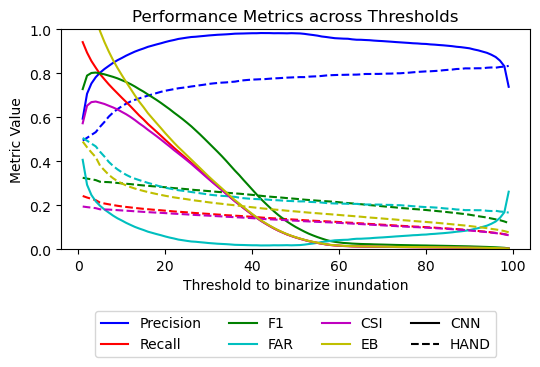

In [11]:

def read_raster_values(raster_file, shapefile):
    """Read raster values and mask with shapefile."""
    with rasterio.open(raster_file) as src:
        # Read the shapefile
        gdf = gpd.read_file(shapefile)
        # Ensure the shapefile and raster have the same CRS
        gdf = gdf.to_crs(src.crs)
        # Mask the raster with the shapefile
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        data = out_image[0]
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 >= true_threshold/100, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    HR = TP / (TP + FN) if TP + FN > 0 else 0
    FAR = FP / (TP + FP) if TP + FP > 0 else 0
    CSI = TP / (TP + FN + FP) if TP + FN + FP > 0 else 0
    EB = (TP + FP) / (TP + FN) if TP + FN > 0 else 0

    return precision, recall, f1, HR, FAR, CSI, EB

# Paths to your data
shapefile_path = f"{LOC_DATA_DIR}shapefile/HUC8_18020104_bbox.shp"
data1_cnn_path = f"{STATS_DIR}NWM-CNN_20230106_20230114.tif"
data1_hand_path = f"{STATS_DIR}NWM-HAND.tif"
data2_path = f"{STATS_DIR}CA_S1.tif"

# Read and mask raster data for both models
data1_cnn = read_raster_values(data1_cnn_path, shapefile_path)
data1_hand = read_raster_values(data1_hand_path, shapefile_path)
data2 = read_raster_values(data2_path, shapefile_path)

# Read raster data
metrics = ['Precision', 'Recall', 'F1', 'FAR', 'CSI', 'EB']
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  # Define colors for each metric
linestyle = '-'
lineweight = 1.5

plt.figure(figsize=(5.5, 4))

f1_scores_cnn = []
f1_scores_hand = []

for metric, color in zip(metrics, colors):
    metric_list_cnn = []
    metric_list_hand = []

    for _threshold in range(1, 100):
        precision_cnn, recall_cnn, f1_cnn, HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, _threshold, _threshold)
        precision_hand, recall_hand, f1_hand, HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, _threshold, _threshold)

        if metric == 'Precision':
            metric_list_cnn.append(precision_cnn)
            metric_list_hand.append(precision_hand)
        elif metric == 'Recall':
            metric_list_cnn.append(recall_cnn)
            metric_list_hand.append(recall_hand)
        elif metric == 'F1':
            metric_list_cnn.append(f1_cnn)
            metric_list_hand.append(f1_hand)
            f1_scores_cnn.append(f1_cnn)  # Store F1 scores for finding the max
            f1_scores_hand.append(f1_hand)  # Store F1 scores for finding the max
        elif metric == 'HR':
            metric_list_cnn.append(HR_cnn)
            metric_list_hand.append(HR_hand)
        elif metric == 'FAR':
            metric_list_cnn.append(FAR_cnn)
            metric_list_hand.append(FAR_hand)
        elif metric == 'CSI':
            metric_list_cnn.append(CSI_cnn)
            metric_list_hand.append(CSI_hand)
        elif metric == 'EB':
            metric_list_cnn.append(EB_cnn)
            metric_list_hand.append(EB_hand)

    plt.plot(list(range(1, 100)), metric_list_cnn, color=color, linestyle="-", lw=lineweight, label=f"{metric} CNN")
    plt.plot(list(range(1, 100)), metric_list_hand, color=color, linestyle="--", lw=lineweight, label=f"{metric} HAND")

# Find the threshold for the maximum F1 score
max_cnn_f1_threshold = np.argmax(f1_scores_cnn) + 1  # Adding 1 because range starts from 1
max_cnn_f1_value = max(f1_scores_cnn)
max_hand_f1_threshold = np.argmax(f1_scores_hand) + 1  # Adding 1 because range starts from 1
max_hand_f1_value = max(f1_scores_hand)

# Custom legend for metrics
legend_elements = [mlines.Line2D([0], [0], color=color, lw=lineweight, label=metric) for metric, color in zip(metrics, colors)]

# Add entries for CNN and HAND
legend_elements.append(mlines.Line2D([0], [0], color='black', lw=lineweight, linestyle='-', label='CNN'))
legend_elements.append(mlines.Line2D([0], [0], color='black', lw=lineweight, linestyle='--', label='HAND'))

# Creating the legend with custom entries
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)

plt.ylim([0, 1])
plt.xlabel("Threshold to binarize inundation")
plt.ylabel("Metric Value")
plt.title("Performance Metrics across Thresholds")
plt.tight_layout()
plt.savefig("binary_curves_hand_cnn.png", dpi=600)
plt.show()
plt.close()
